In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import model_preparation
import lightgbm as lgb
import statsmodels.api as sm
import catboost as cb
import xgboost as xgb

from model_preparation import prepare_data, get_features, get_bounds, get_interval_accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor, Pool

# Load in pre-split data
X_train, X_test, y_train, y_test = prepare_data()
features = get_features()
train_bounds_5 = get_bounds(y_train, 5)
train_bounds_10 = get_bounds(y_train, 10)
test_bounds_5 = get_bounds(y_test, 5)
test_bounds_10 = get_bounds(y_test, 10)

#### GradientBoostingRegressor

In [11]:
# Flatten response variables array to list to use in models
y_train = list(np.array(y_train).flatten())
y_test = list(np.array(y_test).flatten())

In [5]:
# Fit model using ideal hyper-parameters
model = GradientBoostingRegressor(n_estimators=500, max_depth=8, loss='ls', min_samples_split=2, learning_rate=0.01)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
# Compute predictions
y_pred_train_gb = model.predict(X_train)
y_pred_test_gb = model.predict(X_test)

# Compute MSE and R2 scores on testing
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, y_pred_test_gb))


0.9391272481551697
39.39266583401633


In [7]:
# Compute accuracy scores for 5% and 10% intervals on test data
print("5% +/- limit:")
print(get_interval_accuracy_score(test_bounds_5, y_pred_test_gb))
print("10% +/- limit:")
print(get_interval_accuracy_score(test_bounds_10, y_pred_test_gb))

5% +/- limit:
0.52105
10% +/- limit:
0.7261


Text(0, 0.5, 'Deviance')

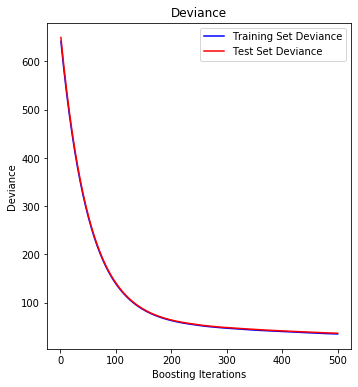

In [15]:
test_score = np.zeros((500,), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

# Plot iterations vs deviance between train and testing 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(500) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(500) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Text(0.5, 1.0, 'Gradient Boost Actual vs. Predicted Values')

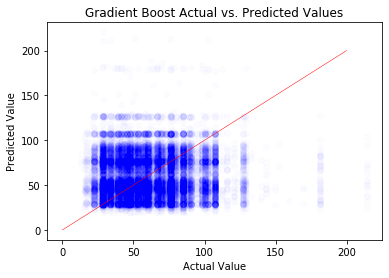

In [16]:
# Plot actuals vs predicted
plt.plot(y_test, y_pred_test_gb, 'bo', alpha = 0.01)
plt.plot([0, 200], [0, 200], color = 'red', linewidth = 0.5)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Gradient Boost Actual vs. Predicted Values")

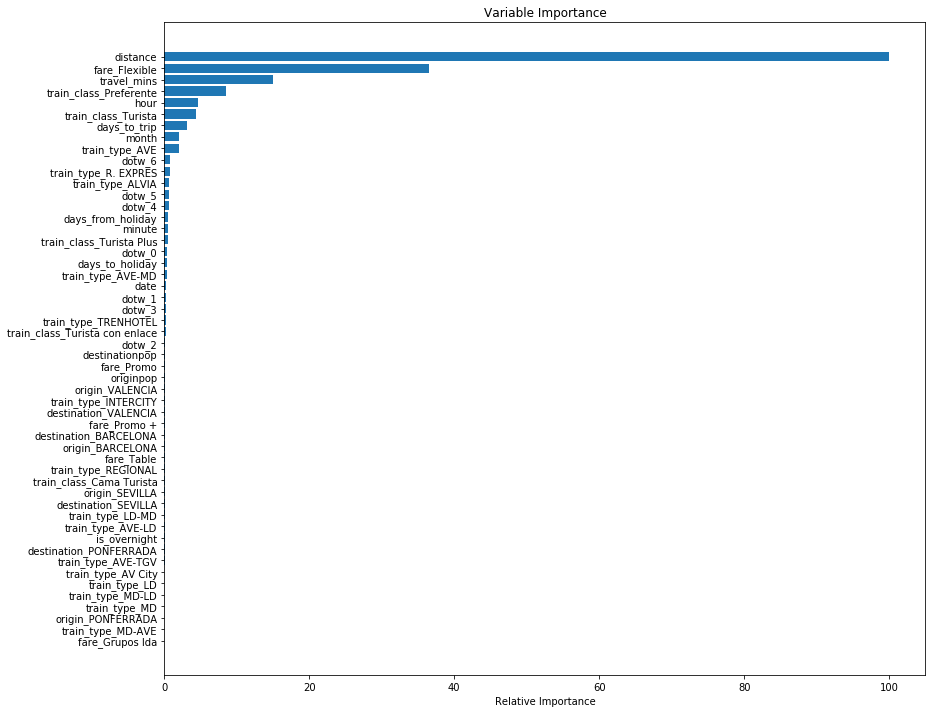

In [17]:
# Compute variable importance for model
indices = np.array(list(range(len(features))))
features = np.array(features)[indices.astype(int)]
feature_importance = model.feature_importances_

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(30, 12))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### XGBoost

In [22]:
xg_train = pd.DataFrame(X_train)
xg_test = pd.DataFrame(X_test)
xg_train.columns = features
xg_test.columns = features

In [33]:
# Perform cross validation to find best hyperparameters for model
cv_params = {'n_estimators': [100, 150, 200], 'max_depth': [6, 8, 10, 12], 
             'eta': [0.1, 0.2, 0.50, 1],'reg_lambda': [1, 3, 5], 'alpha': [0, 0.5, 1, 1.5, 2]}
ind_params = {'objective': 'reg:squarederror', 'seed': 0}


ran = RandomizedSearchCV(xgb.XGBRegressor(**ind_params), cv_params, cv=3, n_jobs=-1, n_iter=10, random_state=0, verbose=2)
ran.fit(xg_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          ran...lpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=0, silent=None, subsample=1,
                              

In [34]:
# Best parameters to use in final model
ran.best_params_

{'n_estimators': 200, 'max_depth': 12, 'lambda': 5, 'eta': 0.2, 'alpha': 1.5}

In [38]:
# Train and fit the model using the best estimators
model = xgb.XGBRegressor(n_estimators=200, eta=0.2, max_depth=12, reg_lambda=5)
model.fit(xg_train, y_train)

[23:00:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=5, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
# Compute predictions
y_pred_train = model.predict(xg_train)
y_pred_test = model.predict(xg_test)

# Compute metrics on testing data
print(r2_score(y_test, y_pred_test))
print(mean_squared_error(y_test, y_pred_test))

0.9720828044865629
18.469253252342327


In [ ]:
# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(get_interval_accuracy_score(test_bounds_5, y_pred_test))
print("10% +/- limit:")
print(get_interval_accuracy_score(test_bounds_10, y_pred_test))

#### CatBoost

In [ ]:
# Perform cross validation to identify best hyper paremeters for model
params = {'iterations': [300, 500, 1000],
        'learning_rate': [0.2, 0.1, 0.01],
        'depth': [6, 8, 10],
        'l2_leaf_reg': [1, 3, 5]}
cbm = CatBoostRegressor()

gs_result = cbm.grid_search(params, X=X_train, y=y_train, plot=True)

In [18]:
# Use best hyper paremeters for model from CV performed above
cbe = cb.CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=10, l2_leaf_reg=1, verbose=0)

In [19]:
# Fit model
cbe.fit(X_train, y_train)

# Compute predictions
cbe_y_preds_test = cbe.predict(X_test)

In [20]:
# Compute R2 and MSE metrics
print(r2_score(y_test, cbe_y_preds_test))
print(mean_squared_error(y_test, cbe_y_preds_test))

0.9743411060128339
16.975222708021604


In [21]:
# Compute accuracy scores for 5% and 10% intervals on test
print("5% +/- limit:")
print(get_interval_accuracy_score(test_bounds_5, cbe_y_preds_test))
print("10% +/- limit:")
print(get_interval_accuracy_score(test_bounds_10, cbe_y_preds_test))

5% +/- limit:
0.6995
10% +/- limit:
0.8754
